# INF-495, v0.01, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
## Textbook: Computational Mathematical Modeling, An Integrated Approach Across Scales by Daniela Calvetti and Erkki Somersalo.

# Chapter 8

## 8.1 Markov process and random walk

In [1]:
import numpy as np
import scipy.sparse.linalg as sp
import sympy as sym
from scipy.linalg import toeplitz

import ipywidgets as widgets
from ipywidgets import IntSlider

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()

from scipy.integrate import odeint
from ipywidgets import interact

def plot_matrices_with_values2(ax,M,flag_values=False):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    ax.matshow(M, cmap=cmap)
    if flag_values:
        for i in np.arange(0, N):
            for j in np.arange(0, N):
                # I had to change the order of indices to make it right
                ax.text(i, j, '{:.2f}'.format(M[j,i]), va='center', ha='center', color='r')

In [2]:
ids = np.arange(64) # Making it Python compatible
I = np.reshape(ids,(8,8),order='F')
print(I)
# Defining occupied squares ([row,columns])
occupied = np.array([[2, 3], [5, 5], [6, 2], [6, 3]])-1 # Subtracting one to make it Python compatible!
print(occupied)
for oc in occupied:
    print(I[oc[0],oc[1]])

[[ 0  8 16 24 32 40 48 56]
 [ 1  9 17 25 33 41 49 57]
 [ 2 10 18 26 34 42 50 58]
 [ 3 11 19 27 35 43 51 59]
 [ 4 12 20 28 36 44 52 60]
 [ 5 13 21 29 37 45 53 61]
 [ 6 14 22 30 38 46 54 62]
 [ 7 15 23 31 39 47 55 63]]
[[1 2]
 [4 4]
 [5 1]
 [5 2]]
17
36
13
21


In [3]:
# Defining the peice
piece = 'King' # 'King' or 'Knight'
if piece == 'King':
    # Squares relative to the current one reached by the King
    Mask = np.zeros((8,2))
    k=0
    piece_range=[-1,0,1]
    for i in piece_range:
        for j in piece_range:
            if not ((i==0) and (j==0)):
                Mask[k,0]=i
                Mask[k,1]=j
                k=k+1
    print(Mask)
elif piece == 'Knight':
    # Squares relative to the current one reached by the Knight
    Mask = np.zeros((8,2))
    k=0
    piece_range=[-2,-1,0,1,2]
    for i in [-2,-1,0,1,2]:
        for j in [-2,-1,0,1,2]:
            if np.linalg.norm([i,j],ord=1)==3:
                Mask[k,0]=i
                Mask[k,1]=j
                k=k+1
    print(Mask)
else:
    print('Wrong piece!')

[[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]


In [4]:
M = np.zeros((64,64))
# Scan through all starting squares
# find all possible destinations
for n in np.arange(8):
    for m in np.arange(8):
        k=I[n,m] # Index to current square
        # Find possible destination square using the mask
        P = np.array([n, m])+Mask
        # Discard occupied squares
        P_tmp=[]
        for p in P:
            flag=0
            for oc_sq in occupied:
                if abs(oc_sq[0]-p[0])+abs(oc_sq[1]-p[1])<1e-10:
                    flag=1
            if flag==0:
                P_tmp.append(p)
        P=np.array(P_tmp,dtype=int)
        # Discarding squares outside the board
        P_tmp=[]
        for p in P:
            if p[0]>=0 and p[0]<=7 and p[1]>=0 and p[1]<=7:
                P_tmp.append(p)
        P=np.array(P_tmp,dtype=int)
        nP = P.shape[0] # number of possible destinations
        # Fill in the probabilities
        for p in P:
            Ip = I[p[0],p[1]] # Destination index
            M[Ip,k] = 1/nP # Moving probability

# Simulating random walk

In [5]:
np.random.seed(0)

nsteps = 100
prev   = I[1,2]
ncounts = np.zeros(64)
squares_ids = [prev]
for n in np.arange(nsteps):
    # Random draw using the column M[:,prev]
    next_step = np.random.choice(np.arange(64),p=M[:,prev])
    ncounts[next_step] = ncounts[next_step] + 1
    prev = next_step
    squares_ids.append(next_step)
print(ncounts)
print(squares_ids)
print(I)

[4. 4. 4. 2. 4. 1. 0. 0. 1. 6. 2. 7. 2. 0. 0. 0. 1. 0. 4. 3. 1. 0. 0. 0.
 0. 0. 3. 2. 1. 0. 0. 0. 0. 2. 2. 2. 0. 0. 0. 0. 1. 2. 1. 3. 1. 0. 0. 0.
 1. 2. 5. 8. 2. 2. 0. 0. 1. 2. 2. 5. 3. 0. 1. 0.]
[17, 18, 26, 33, 34, 33, 40, 41, 50, 59, 51, 59, 52, 53, 62, 53, 44, 35, 43, 51, 59, 60, 59, 52, 60, 51, 58, 49, 58, 51, 50, 43, 51, 50, 51, 42, 43, 50, 51, 60, 59, 51, 50, 57, 48, 56, 57, 49, 41, 34, 27, 26, 27, 35, 26, 19, 11, 18, 10, 9, 1, 0, 1, 9, 0, 1, 2, 11, 2, 11, 2, 11, 10, 19, 20, 28, 19, 12, 3, 4, 3, 4, 5, 4, 11, 12, 4, 11, 2, 9, 18, 11, 18, 9, 16, 9, 1, 8, 0, 9, 0]
[[ 0  8 16 24 32 40 48 56]
 [ 1  9 17 25 33 41 49 57]
 [ 2 10 18 26 34 42 50 58]
 [ 3 11 19 27 35 43 51 59]
 [ 4 12 20 28 36 44 52 60]
 [ 5 13 21 29 37 45 53 61]
 [ 6 14 22 30 38 46 54 62]
 [ 7 15 23 31 39 47 55 63]]


In [6]:
def plot_P_n(nj, I, M):
    # Defining initial distribution
    (i0,j0)=(0,1)
    pcurr = np.zeros(64)
    pcurr[I[i0,j0]] = 1
    for j in np.arange(nj):
        pcurr = np.dot(M,pcurr)
    pcurrM = np.reshape(pcurr,(8,8),order='F')
    fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
    plot_matrices_with_values2(ax1,np.log10(np.reshape(pcurr,(8,8),order='F')),True)
interact(lambda nj=2: plot_P_n(nj, I=I, M=M), nj = (0,2000,1))

interactive(children=(IntSlider(value=2, description='nj', max=2000), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(nj=2)>

## Bonus

In [12]:
w, v = np.linalg.eig(M)

In [13]:
w

array([ 1.        ,  0.94242218,  0.93535358,  0.87570847,  0.7641552 ,
        0.75747923,  0.70472958,  0.68840731,  0.53945617,  0.44362115,
        0.43994424,  0.39317436,  0.36225462,  0.30523264,  0.27731892,
        0.15125504,  0.14733235, -0.53870554, -0.52791719, -0.50773004,
       -0.50226771,  0.10782438,  0.09034742, -0.45795139,  0.05152279,
        0.02911406,  0.01462227, -0.43568594, -0.41836953, -0.41085346,
       -0.40468406, -0.39082156, -0.35670216, -0.34186859, -0.33240971,
       -0.3233874 , -0.03297182, -0.04392024, -0.29146884, -0.07726321,
       -0.08939791, -0.09913536, -0.26698113, -0.2575653 , -0.25088564,
       -0.239291  , -0.23275389, -0.2275247 , -0.2077315 , -0.20445031,
       -0.20052018, -0.12751342, -0.16732944, -0.16591746, -0.13918589,
       -0.14689862, -0.14898567, -0.15031674, -0.15159525, -0.15231812,
        0.        ,  0.        ,  0.        ,  0.        ])

In [14]:
v0=v[:,0]/np.sum(v[:,0])

/Users/claudio/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


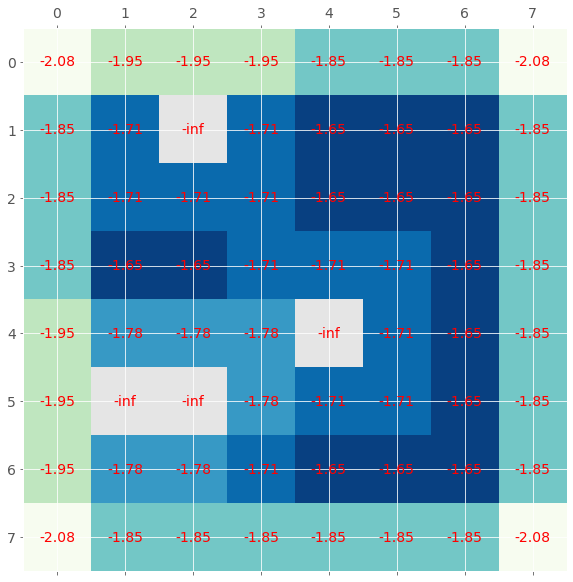

In [15]:
fig,  (ax1)   = plt.subplots(1, 1, figsize=(10,10))
plot_matrices_with_values2(ax1,np.log10(np.reshape(v0,(8,8),order='F')),True)

# 8.2 Stochastic predator-prey model

In [11]:
def plot_S_Pred_Prey(seed=0):
    Nj       = 200 # number of X adult pair at t = t(j)
    Mj       = 50  # number of Y adult pair at t = t(j)
    p_mean   = 10  # mean number of X offsprings/adult pair
    p_std    = 3   # std of the number of the X offspring/adult pair
    beta     = 0.3 # Survival probability of X in the absence of Y
    Mstar    = 50  # number of Y that halves the survival prob. of X
    q_mean   = 4   # mean number of Y offspring/adult pair
    q_std    = 2   # std of the number of the Y offsrping/adult pair
    gamma    = 0.6 # Survival prob. of Y in adundance of X
    Nstar    = 400 # Number of X pairs at which the survival prob. of Y is halved

    nrounds  = 40  # Number of generations allowed

    N = np.full(nrounds,np.nan)
    N[0] = Nj
    M = np.full(nrounds,np.nan)
    M[0] = Mj
    Surv = np.full((nrounds-1,2),np.nan)

    np.random.seed(seed)

    for j in np.arange(1,nrounds):
        # Draw the number of offsprings of species X
        Pj = Nj*p_mean+np.sqrt(Nj)*p_std*np.random.randn()
        # Survival probability of the offspring of species X
        s = beta/(1+(Mj/Mstar)**2)
        Nj = s*Pj+np.sqrt(s*Pj*(1-s))*np.random.randn()
        N[j] = 0.5*Nj
        # Draw the number of offsprings of species Y
        Qj = Mj*q_mean+np.sqrt(Mj)*q_std*np.random.randn()
        # Survival probability of the offspring of species Y
        r = gamma*(1-1/(1+(Nj/Nstar)**2))
        Mj = r*Qj+np.sqrt(r*Qj*(1-r))*np.random.randn()
        M[j] = 0.5*Mj
        # Saving the survival probabilities for later analysis
        Surv[j-1,:]=[s,r]

    s=Surv[:,0]
    r=Surv[:,1]
    
    smean = np.sum(s)/(nrounds-1)
    rmean = np.sum(r)/(nrounds-1)
    Surv_c = Surv-np.array([smean,rmean])
    covSurv = np.dot(Surv_c.T,Surv_c)/(nrounds-1)
    corrcoeff = covSurv[0,1]/np.sqrt(covSurv[0,0]*covSurv[1,1])
        
    fig,  ((ax1,ax2),(ax3,ax4))   = plt.subplots(2, 2, figsize=(10,10))
    
    ax4.plot(N,'r.-')
    ax4.plot(M,'b.-')
    ax4.grid(True)
    
    s=Surv[:,0]
    r=Surv[:,1]
    ax1.plot(s,r,'.')
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_xlabel(r'$s_i$')
    ax1.set_ylabel(r'$r_i$')
    ax1.text(0.5, 0.2, 'c={:.5f}'.format(corrcoeff), va='center', ha='center', color='k')
    
    ax2.hist(r,orientation='horizontal')
    ax2.set_ylim(0,1)
    
    ax3.hist(s)
    ax3.set_xlim(0,1)
    
    plt.show()
interact(plot_S_Pred_Prey,seed=(0,100,1))

interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_S_Pred_Prey(seed=0)>